# SWITCH TO **`T4 GPU`** OR THE **`HPC`**

# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import re
from keras.callbacks import ModelCheckpoint, LambdaCallback
from PIL import Image

2025-05-09 23:55:21.105830: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 23:55:22.689100: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 23:55:22.712782: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-09 23:55:33.896470: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import platform
print(platform.system())

Linux


In [3]:
# makes it so pd dfs aren't truncated

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# 1) DATA PRE-PROCESSING

a) Load in kaggle data labels + image file paths

b) combine kaggle data labels and image file paths into one dataframe

c) load in the extra 486 image file paths

d) extract the speed and angle labels from the file path names

e) store that extra data in a pandas df and do the value normalisation

f) merge the kaggle and extra data dfs

g) EDA

h) convert the images to numerical RGB feature maps

i) split data into training-validation sets

j) data augmentation applied to training set

### 1a) load in kaggle data labels + image file paths

In [5]:
# labels_file_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_norm.csv' # tylers file path
labels_file_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_norm.csv' # ben hpc file path (mlis2 cluster)
# labels_file_path = '/home/ppytr13/machine-learning-in-science-ii-2025/training_norm.csv' # tyler hpc file path (mlis2 cluster)
labels_df = pd.read_csv(labels_file_path, index_col='image_id')

In [6]:
image_folder_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data' # OG data ben hpc file path (mlis2 cluster)
# image_folder_path = '/home/ppytr13/machine-learning-in-science-ii-2025//training_data/training_data'
# image_folder_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data' # tylers file path
image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'

Checking labels dataframe

In [7]:
labels_df.head()

,angle,speed
image_id,,
1,0.4375,0.0
2,0.8125,1.0
3,0.4375,1.0
4,0.6250,1.0
5,0.5000,0.0


Checking image file paths dataframe - as you can see the file paths are ordered correctly (1.png, 2.png, 3.png, ...)

In [8]:
imagefilepaths_df.head()

,image_file_paths
image_id,
1,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/1.png
2,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/2.png
3,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3.png
4,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/4.png
5,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/5.png


### 1b) Combine the kaggle labels and image file paths into one dataframe

In [9]:
kaggle_df = pd.merge(labels_df, imagefilepaths_df, on='image_id', how='inner')
kaggle_df['speed'] = kaggle_df['speed'].round(6) # to get rid of floating point errors

In [10]:
kaggle_df.tail()

,angle,speed,image_file_paths
image_id,,,
13794,0.6250,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13794.png
13795,0.4375,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13795.png
13796,0.5625,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13796.png
13797,0.6250,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13797.png
13798,0.6875,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13798.png


In [11]:
kaggle_df.loc[3139:3143]

,angle,speed,image_file_paths
image_id,,,
3139,0.750,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3139.png
3140,0.875,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3140.png
3142,0.625,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3142.png
3143,0.625,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3143.png


The above cell shows that:

 1) the image files and labels match (see image_id and the number at the end of the file path)

 2) the missing rows in labels_df (image_id: 3141, 3999, 4895, 8285, 10171) have been taken care of

### 1c) load in the extra 486 labels image file paths

In [12]:
# petrudata_folder_path = '/home/apyba3/petru_data'
# bendata_folder_path = '/home/apyba3/bendata_1st_set'

In [13]:
# def extract_filepaths(extradata_folderpath):
#     extradata_file_paths = [
#     os.path.join(extradata_folderpath, f)
#     for f in os.listdir(extradata_folderpath)
#     if f.lower().endswith(('.png', '.jpg', '.jpeg'))
#     ]
#     return extradata_file_paths

### 1d) extract the speed and angle labels from the file path names

image file path name follows the pattern: `randomnumber_angle_speed`

In [14]:
# def loadin_extradata(extradata_folderpath):
#     extracted_filepaths = extract_filepaths(extradata_folderpath)
#     # Regex pattern to extract angle and speed values
#     pattern = r'(\d+)_(\d+)_(\d+)\.png'  # Fixed pattern to capture groups correctly

#     angle_value = []
#     speed_value = []

#     # Loop through file paths and extract angle and speed values
#     for file_path in extracted_filepaths:
#         match = re.search(pattern, file_path)
#         if match:
#             # Extract random number, angle, and speed values
#             random_number = match.group(1)
#             angle_value.append(int(match.group(2)))
#             speed_value.append(int(match.group(3)))
#         else:
#             print(f"No match found for file: {file_path}")

#     return angle_value, speed_value

checking it has stored the labels correctly (check if the angle_value order matches that of the file path)

### 1e) store that extra data in a pandas df and do the value normalisation

In [15]:
# def create_df_and_normalisation(folder_path):
#     max_image_id = len(loadin_extradata(folder_path)[0])
#     df = pd.DataFrame(
#         {
#             'angle': loadin_extradata(folder_path)[0],
#             'speed': loadin_extradata(folder_path)[1],
#             'image_file_paths': extract_filepaths(folder_path)
#         }
#     )

#     df.loc[df['speed'] > 0, 'speed'] = 1
#     df['angle'] = (df['angle'] - 50)/80
#     return df

# def combine_dfs_add_imageid(df1, df2):
#     combined_df = pd.concat([df1, df2], ignore_index=True)
#     combined_df.index = pd.RangeIndex(start=13799, stop=13799 + len(combined_df), step=1)
#     combined_df.index.name = 'image_id'
#     return combined_df

# bendata_df = create_df_and_normalisation(bendata_folder_path)
# petrudata_df = create_df_and_normalisation(petrudata_folder_path)

# combinedextradata_df = combine_dfs_add_imageid(bendata_df, petrudata_df)
# display(combinedextradata_df.tail())

### 1f) merge the kaggle and extra data dfs

In [16]:
# merged_df = pd.concat([kaggle_df, combinedextradata_df])

### 1g) check for corrupted images and get rid of them

In [17]:
# def validate_image_files(dataframe):
#     """
#     Check each image file in the dataframe and return a new dataframe with only valid files.
#     Also prints information about invalid files.
#     """
#     valid_rows = []
#     invalid_files = []
    
#     print(f"Checking {len(dataframe)} image files...")
    
#     for index, row in dataframe.iterrows():
#         path = row['image_file_paths']
        
#         # # Print every 100 files to show progress
#         # if len(valid_rows) % 100 == 0 and len(valid_rows) > 0:
#         #     print(f"Processed {len(valid_rows) + len(invalid_files)} files, {len(valid_rows)} valid...")
        
#         try:
#             # Basic file checks
#             if not os.path.exists(path):
#                 # print(f"File does not exist: {path}")
#                 invalid_files.append(path)
#                 continue
                
#             if os.path.getsize(path) == 0:
#                 # print(f"File is empty: {path}")
#                 invalid_files.append(path)
#                 continue
            
#             # Try to open the image with PIL to verify it's valid
#             with Image.open(path) as img:
#                 # Just accessing img.size will verify the image can be read
#                 width, height = img.size
            
#             # If we get this far, the image is valid
#             valid_rows.append(row)
                
#         except Exception as e:
#             print(f"Error with {path}: {e}")
#             invalid_files.append(path)
    
#     # Create a new dataframe with only valid rows
#     valid_df = pd.DataFrame(valid_rows)
    
#     print(f"\nValidation complete: {len(valid_df)} valid files, {len(invalid_files)} invalid files")
    
#     # if invalid_files:
#     #     print("\nFirst few invalid files:")
#     #     for path in invalid_files[:5]:
#     #         print(f"  - {path}")
    
#     return valid_df

# # Run the validation
# valid_df = validate_image_files(merged_df)

### 1h) EDA

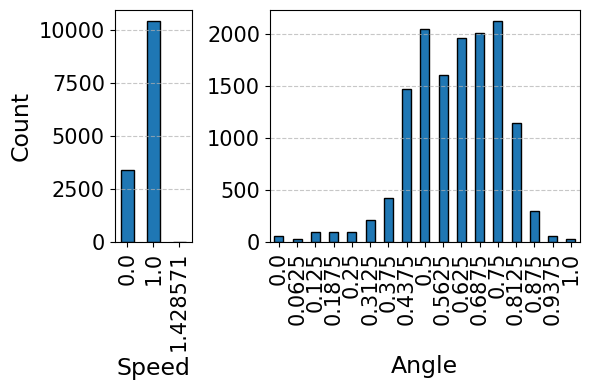

In [18]:
# Get value counts
speed_counts = kaggle_df['speed'].value_counts().sort_index()
angle_counts = kaggle_df['angle'].value_counts().sort_index()

# Create subplots with custom width ratios
fig, axes = plt.subplots(1, 2, figsize=(6, 4), gridspec_kw={'width_ratios': [1,4]})  # Speed plot narrower

# Plot speed
speed_counts.plot(kind='bar', edgecolor='black', ax=axes[0])
# axes[0].set_title('Speed', fontsize=15)
axes[0].set_xlabel('Speed', fontsize=17)
axes[0].set_ylabel('Count', fontsize=17)
axes[0].tick_params(axis='both', labelsize=15)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot angle
angle_counts.plot(kind='bar', edgecolor='black', ax=axes[1])
# axes[1].set_title('Angle', fontsize=15)
axes[1].set_xlabel('Angle', fontsize=17, labelpad=22)
# axes[1].set_ylabel('Count', fontsize=17)
axes[1].tick_params(axis='both', labelsize=15)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and save
plt.tight_layout()
plt.savefig('speed_angle_distribution.pdf', format='pdf')
plt.show()

In [19]:
kaggle_df.value_counts('speed')

speed
1.000000    10402
0.000000     3390
1.428571        1
Name: count, dtype: int64

note: imbalance datset

we want to remove the row containing the erroneous 1.428571 speed value

In [20]:
cleaned_df = kaggle_df[kaggle_df['speed'] != 1.428571]

In [21]:
cleaned_df.value_counts('speed')

speed
1.0    10402
0.0     3390
Name: count, dtype: int64

### 1i) do a stratified train-validation split & convert images to numerical RGB feature maps

In [22]:
BATCH_SIZE = 32

In [23]:
# def process_image(image_path, label, resized_shape=(224, 224)):
#     image = tf.io.read_file(image_path)
#     image = tf.image.decode_jpeg(image, channels=3)
#     image = tf.image.resize(image, resized_shape)
#     image = image / 255.0  # Normalise pixel values to [0,1]
#     return image, label

# dataset = tf.data.Dataset.from_tensor_slices((cleaned_df["image_file_paths"], cleaned_df["speed"])) # Convert pd df into a tf ds

# dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

# dataset = dataset.cache()
# dataset = dataset.shuffle(len(cleaned_df))
# dataset = dataset.batch(BATCH_SIZE)
# dataset = dataset.prefetch(tf.data.AUTOTUNE)

import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# Start with dataframe columns
image_paths = cleaned_df["image_file_paths"].values
speed_labels = cleaned_df["speed"].values

# Perform stratified split on the raw data
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, 
    speed_labels,
    test_size=0.2,
    random_state=42,
    stratify=speed_labels  # This ensures same distribution
)

# Process function remains the same
def process_image(image_path, label, resized_shape=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, resized_shape)
    image = image / 255.0
    return image, label

# Create separate datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(len(train_paths))
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

2025-05-09 23:55:58.231502: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


check to see if the distributions are the same

2025-05-09 23:56:08.413052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6400 of 11033
2025-05-09 23:56:10.198024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.



Training Set Distribution:
------------------------------
Class 0.0: 2712 samples (24.58%)
Class 1.0: 8321 samples (75.42%)


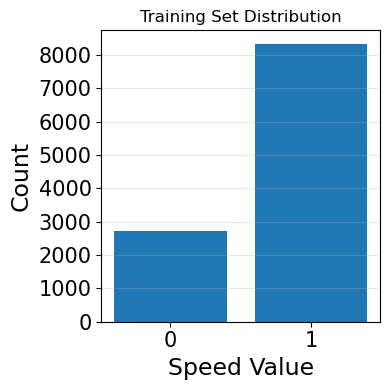


Validation Set Distribution:
------------------------------
Class 0.0: 678 samples (24.57%)
Class 1.0: 2081 samples (75.43%)


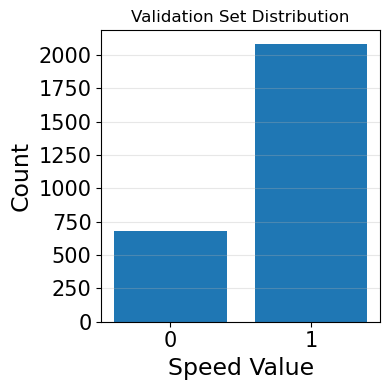

In [24]:
def check_distribution(dataset, name):
    # Collect all labels from the dataset
    all_labels = []
    for _, labels in dataset:
        # If batched, need to extract from batch
        if isinstance(labels, tf.Tensor) and len(labels.shape) > 0:
            all_labels.extend(labels.numpy())
        else:
            all_labels.append(labels.numpy())
    
    # Convert to numpy array
    all_labels = np.array(all_labels)
    
    # Count occurrences of each class
    unique_values, counts = np.unique(all_labels, return_counts=True)
    
    # Calculate percentages
    total = len(all_labels)
    percentages = (counts / total) * 100
    
    # Print results
    print(f"\n{name} Set Distribution:")
    print("-" * 30)
    for value, count, percentage in zip(unique_values, counts, percentages):
        print(f"Class {value}: {count} samples ({percentage:.2f}%)")
    
    # Create a simple bar chart
    plt.figure(figsize=(4, 4))
    plt.bar(unique_values, counts)
    plt.title(f"{name} Set Distribution")
    plt.xlabel('Speed Value', fontsize=17)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Count', fontsize=17)
    plt.xticks(unique_values)
    plt.grid(axis='y', alpha=0.3)
    
    # Add count labels on top of bars
    # for i, count in enumerate(counts):
    #     plt.text(unique_values[i], count + (max(counts) * 0.01), 
    #              f"{count}\n({percentages[i]:.1f}%)", 
    #              ha='center')
    
    plt.tight_layout()
    plt.show()

# Check both datasets
check_distribution(train_dataset, "Training")
check_distribution(val_dataset, "Validation")

lets check and see if what we have done works

In [25]:
for images, labels in train_dataset.take(1):
    print(images.shape, labels.shape)

(32, 224, 224, 3) (32,)


### 1j) Splitting data into training and validation sets (test set is already provided in kaggle data)

In [26]:
# # 85-15 split

# dataset_size = tf.data.experimental.cardinality(dataset).numpy()
# train_size = int(0.85 * dataset_size)

# train_dataset = dataset.take(train_size)
# val_dataset = dataset.skip(train_size)

In [27]:
# print(f"Train size: {train_size}, validation size: {dataset_size - train_size}")

### 1k) Data Augmentation applied to training set

- Random Brightness Adjustment
- Random Contrast Adjustment
- Random Hue Adjustment
- Random Saturation Adjustment
- Random Horizontal Flip



In [28]:
def augment_image(image, label):
  seed = (6, 9)
  image = tf.image.stateless_random_brightness(image, 0.2, seed)
  image = tf.image.stateless_random_contrast(image, 0.8, 1.2, seed)
  image = tf.image.stateless_random_hue(image, 0.2, seed)
  image = tf.image.stateless_random_saturation(image, 0.8, 1.2, seed)
  image = tf.image.stateless_random_flip_left_right(image, seed)
  return image, label

# Create a dataset of augmented images from the original train_dataset
augmented_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

# Concatenate the original and augmented datasets
train_dataset = train_dataset.concatenate(augmented_dataset)

# Shuffle the combined dataset
train_dataset = train_dataset.shuffle(buffer_size=len(cleaned_df))

In [29]:
angle_list = []

for image_batch, label_batch in train_dataset:
    angle_list.extend(label_batch.numpy())  # add all 32 values from the batch

angle_distribution = pd.Series(angle_list).value_counts().sort_index()
print(angle_distribution)


0.0     5424
1.0    16642
Name: count, dtype: int64


count how many images are in the training set - 22016 with no extradata and 80-20 split

In [30]:
total_images = 0
for image_batch, _ in train_dataset:
    total_images += image_batch.shape[0]  # Add the batch size

print(f"Total number of images in train_dataset: {total_images}")

Total number of images in train_dataset: 22066


checking to see if whats been done was successful or needs debugging

image shape:  (224, 224, 3)
label: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image shape:  (224, 224, 3)
label: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image shape:  (224, 224, 3)
label: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


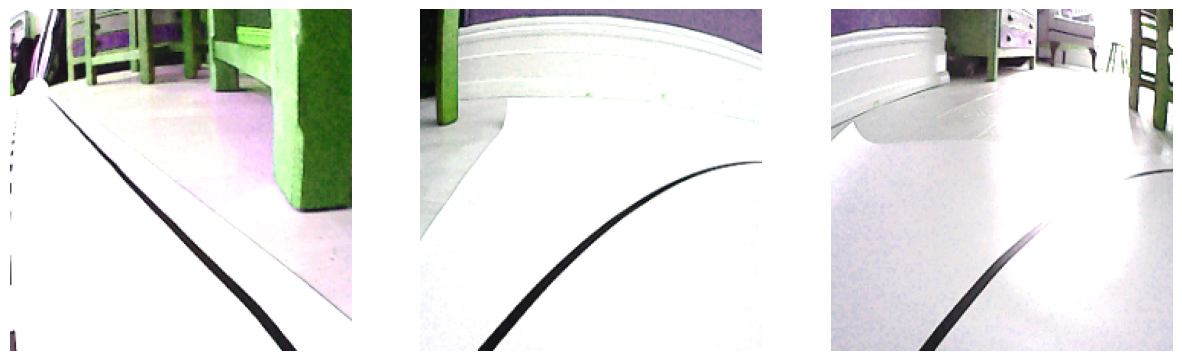

<Figure size 640x480 with 0 Axes>

In [31]:
f, axarr = plt.subplots(1,3, figsize=(15, 5))

i = 0
for image_batch, label_batch in train_dataset.take(1):  # Take one batch
    for image in image_batch:  # Iterate through images in the batch
        if i < 3:  # Only display the first 5 images
            print('image shape: ', np.shape(image))
            tf.print('label:', label_batch[i])  # Print label for the corresponding image
            axarr[i].imshow(image)
            axarr[i].axis('off')
            i += 1
        else:
            break  # Stop after displaying 5 images
plt.show()
plt.savefig('augmented_images.pdf', format='pdf')

# 2) CLASSIFICATION SPEED Model Building - MobNetV3Small Transfer Learning

### 2a) Set up model architecture

In [32]:
dropoutrate = 0.2
input_shape = (224,224,3)
num_classes = 1 # we're only predicting the prob of the positive class

In [33]:
mobnetv3small = tf.keras.applications.MobileNetV3Large(
    weights = 'imagenet',
    include_top = False,
    input_shape = input_shape
)

model = tf.keras.Sequential([
  mobnetv3small,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

mobnetv3small.trainable = False  # freeze mobnetv3small layers

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 256)               246016    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               3

compile the model

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.F1Score(name='f1_score')]
)

### 2c) train the model with the mobnetv3small layers frozen

In [35]:
class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min'):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.save_best_only = save_best_only
        
        # Initialize best value based on mode
        self.mode = mode
        if mode == 'min':
            self.best = float('inf')
            self.monitor_op = lambda current, best: current < best
        else:  # 'max'
            self.best = float('-inf')
            self.monitor_op = lambda current, best: current > best
            
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        
        if current is None:
            if self.verbose > 0:
                print(f"Warning: {self.monitor} not found in logs")
            return
            
        if self.save_best_only:
            if self.monitor_op(current, self.best):
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} improved from {self.best:.4f} to {current:.4f}")
                    print(f"Saving model to {self.filepath}")
                self.best = current
                
                # Use direct model.save() without extra parameters
                try:
                    self.model.save(self.filepath)
                except Exception as e:
                    print(f"Error saving model: {e}")
        else:
            if self.verbose > 0:
                print(f"\nEpoch {epoch+1}: saving model to {self.filepath}")
            try:
                self.model.save(self.filepath)
            except Exception as e:
                print(f"Error saving model: {e}")


In [36]:
# # Define checkpoint directory and create it if it doesn't exist
# checkpoint_dir = '/home/apyba3/PICAR-autopilot/MobNetV3Small_Kaggle/checkpoints'
# os.makedirs(checkpoint_dir, exist_ok=True)

# # Define checkpoint filepath
# checkpoint_filepath = os.path.join(checkpoint_dir, '50epochs_frozen_mobnetv3smallcheckpoint.keras')

# # Create custom checkpoint callback
# custom_checkpoint = CustomModelCheckpoint(
#     filepath=checkpoint_filepath,
#     monitor='val_loss',
#     save_best_only=True,
#     mode='min',
#     verbose=1
# )

# # Define epoch callback 
# epoch_callback = LambdaCallback(
#     on_epoch_begin=lambda epoch, logs: print(f"\nStarting Epoch {epoch + 1}..."),
#     on_epoch_end=lambda epoch, logs: print(f"Completed Epoch {epoch + 1}, Loss: {logs['loss']:.4f}, Val Loss: {logs['val_loss']:.4f}")
# )

# # Training with callbacks
# history = model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=50,
#     callbacks=[custom_checkpoint, epoch_callback]
# )

In [37]:
# Define checkpoint directory and create it if it doesn't exist
checkpoint_dir = '/home/apyba3/PICAR-autopilot/V3Largecheckpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define checkpoint filepath for the finetuned model
checkpoint_filepath = os.path.join(checkpoint_dir, 'V3Large_classif_checkpoint.keras')

# Use the existing CustomModelCheckpoint class (no need to redefine it)
# Just create a new instance with the updated filepath
custom_checkpoint = CustomModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Define epoch callback 
epoch_callback = LambdaCallback(
    on_epoch_begin=lambda epoch, logs: print(f"\nStarting Epoch {epoch + 1}..."),
    on_epoch_end=lambda epoch, logs: print(f"Completed Epoch {epoch + 1}, Loss: {logs['loss']:.4f}, Val Loss: {logs['val_loss']:.4f}")
)

from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.001,
    mode='min',
    restore_best_weights=True,  # This loads the best weights into model memory when stopping
    verbose=1
)

# Train with both callbacks
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[custom_checkpoint, epoch_callback, early_stopping]
)


Starting Epoch 1...
Epoch 1/100
690/690 [==============================] - ETA: 0s - loss: 0.3967 - accuracy: 0.8320 - f1_score: 0.8599
Epoch 1: val_loss improved from inf to 0.4234
Saving model to /home/apyba3/PICAR-autopilot/V3Largecheckpoints/V3Large_classif_checkpoint.keras
Completed Epoch 1, Loss: 0.3967, Val Loss: 0.4234
690/690 [==============================] - 163s 223ms/step - loss: 0.3967 - accuracy: 0.8320 - f1_score: 0.8599 - val_loss: 0.4234 - val_accuracy: 0.7927 - val_f1_score: 0.8599

Starting Epoch 2...
Epoch 2/100
690/690 [==============================] - ETA: 0s - loss: 0.2849 - accuracy: 0.8856 - f1_score: 0.8599
Epoch 2: val_loss improved from 0.4234 to 0.2700
Saving model to /home/apyba3/PICAR-autopilot/V3Largecheckpoints/V3Large_classif_checkpoint.keras
Completed Epoch 2, Loss: 0.2849, Val Loss: 0.2700
690/690 [==============================] - 159s 222ms/step - loss: 0.2849 - accuracy: 0.8856 - f1_score: 0.8599 - val_loss: 0.2700 - val_accuracy: 0.8793 - val_

In [38]:
# # the training metrics from the above frozen training (i forgot to save the history lol)
# epochs = list(range(1, 29))  # Epochs 1-28

# # Training metrics
# train_loss = [0.5478, 0.5288, 0.5184, 0.5062, 0.5010, 0.4935, 0.4901, 0.4882, 0.4844, 0.4845, 
#               0.4763, 0.4775, 0.4819, 0.4760, 0.4781, 0.4763, 0.4793, 0.4746, 0.4805, 0.4688, 
#               0.4707, 0.4688, 0.4700, 0.4695, 0.4680, 0.4652, 0.4647, 0.4638]

# train_acc = [0.7675, 0.7672, 0.7660, 0.7733, 0.7756, 0.7785, 0.7762, 0.7790, 0.7812, 0.7824, 
#              0.7873, 0.7832, 0.7819, 0.7840, 0.7824, 0.7828, 0.7815, 0.7826, 0.7819, 0.7850, 
#              0.7858, 0.7874, 0.7859, 0.7868, 0.7862, 0.7890, 0.7905, 0.7910]

# train_auc = [0.5194, 0.6125, 0.6530, 0.6753, 0.6876, 0.7039, 0.7143, 0.7171, 0.7213, 0.7197, 
#              0.7336, 0.7323, 0.7268, 0.7385, 0.7328, 0.7366, 0.7326, 0.7416, 0.7278, 0.7495, 
#              0.7455, 0.7484, 0.7443, 0.7490, 0.7483, 0.7522, 0.7541, 0.7542]

# # Validation metrics
# val_loss = [0.5390, 0.5093, 0.4670, 0.5031, 0.4770, 0.4552, 0.4561, 0.4518, 0.4640, 0.4715, 
#             0.4377, 0.4869, 0.4567, 0.4294, 0.4301, 0.5054, 0.4673, 0.4150, 0.4413, 0.4280, 
#             0.4735, 0.4311, 0.4387, 0.4435, 0.4491, 0.4722, 0.5282, 0.4491]

# val_acc = [0.7621, 0.7663, 0.7984, 0.7778, 0.7669, 0.7797, 0.8390, 0.7754, 0.7754, 0.7869, 
#            0.7833, 0.7645, 0.7663, 0.7906, 0.7990, 0.7567, 0.7760, 0.8039, 0.7851, 0.7791, 
#            0.7500, 0.7966, 0.7742, 0.7772, 0.7645, 0.7645, 0.7597, 0.7645]

# val_auc = [0.7274, 0.8145, 0.8187, 0.8443, 0.8552, 0.8605, 0.8613, 0.8751, 0.8746, 0.8534, 
#            0.8845, 0.8693, 0.8840, 0.8822, 0.8844, 0.8816, 0.8688, 0.8696, 0.8802, 0.8964, 
#            0.8902, 0.8979, 0.9097, 0.8863, 0.8806, 0.8762, 0.8891, 0.9082]

# # Best epoch information
# best_epoch = 18
# best_val_loss = 0.4150

In [47]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_curves(history, save_path=None, fontsize=14):
    """
    Create a professional-looking loss curve plot with training and validation curves.

    Args:
        history: The history object returned by model.fit()
        save_path: Path to save the plot (without extension)
        fontsize: Font size for labels, ticks, and legend
    """
    # Create figure with appropriate size
    plt.figure(figsize=(8, 6), dpi=300)
    
    # Epochs on X-axis
    epochs = range(1, len(history.history['loss']) + 1)
    
    # Plot training and validation loss
    plt.plot(epochs, history.history['loss'], 'o-', color='blue', linewidth=2, 
             markersize=4, label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 's-', color='red', linewidth=2, 
             markersize=4, label='Validation Loss')
    
    # Labels
    plt.xlabel('Epoch', fontsize=fontsize)
    plt.ylabel('Loss', fontsize=fontsize)
    
    # Integer ticks for epochs
    plt.xticks(ticks=np.arange(0, len(epochs) + 1, 3), fontsize=fontsize)

    plt.yticks(fontsize=fontsize)
    
    # Grid, legend, and ticks
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=16, loc='upper right')
    
    plt.minorticks_on()
    plt.tick_params(axis='both', which='minor', length=4, color='gray', labelsize=fontsize)
    plt.tick_params(axis='both', which='major', length=6, color='black', labelsize=fontsize)
    plt.tick_params(top=True, right=True, direction='in', length=6)
    plt.tick_params(which='minor', top=True, right=True, direction='in', length=4)
    
    # Layout and save
    plt.tight_layout()
    if save_path:
        plt.savefig(f"{save_path}.pdf", bbox_inches='tight')
        plt.savefig(f"{save_path}.png", bbox_inches='tight', dpi=300)
        print(f"Loss curves saved to {save_path}.pdf and {save_path}.png")
    
    plt.show()

Loss curves saved to V3Large_speedclassif_stratsplit_earlystop_frozen_losscurves.pdf and V3Large_speedclassif_stratsplit_earlystop_frozen_losscurves.png


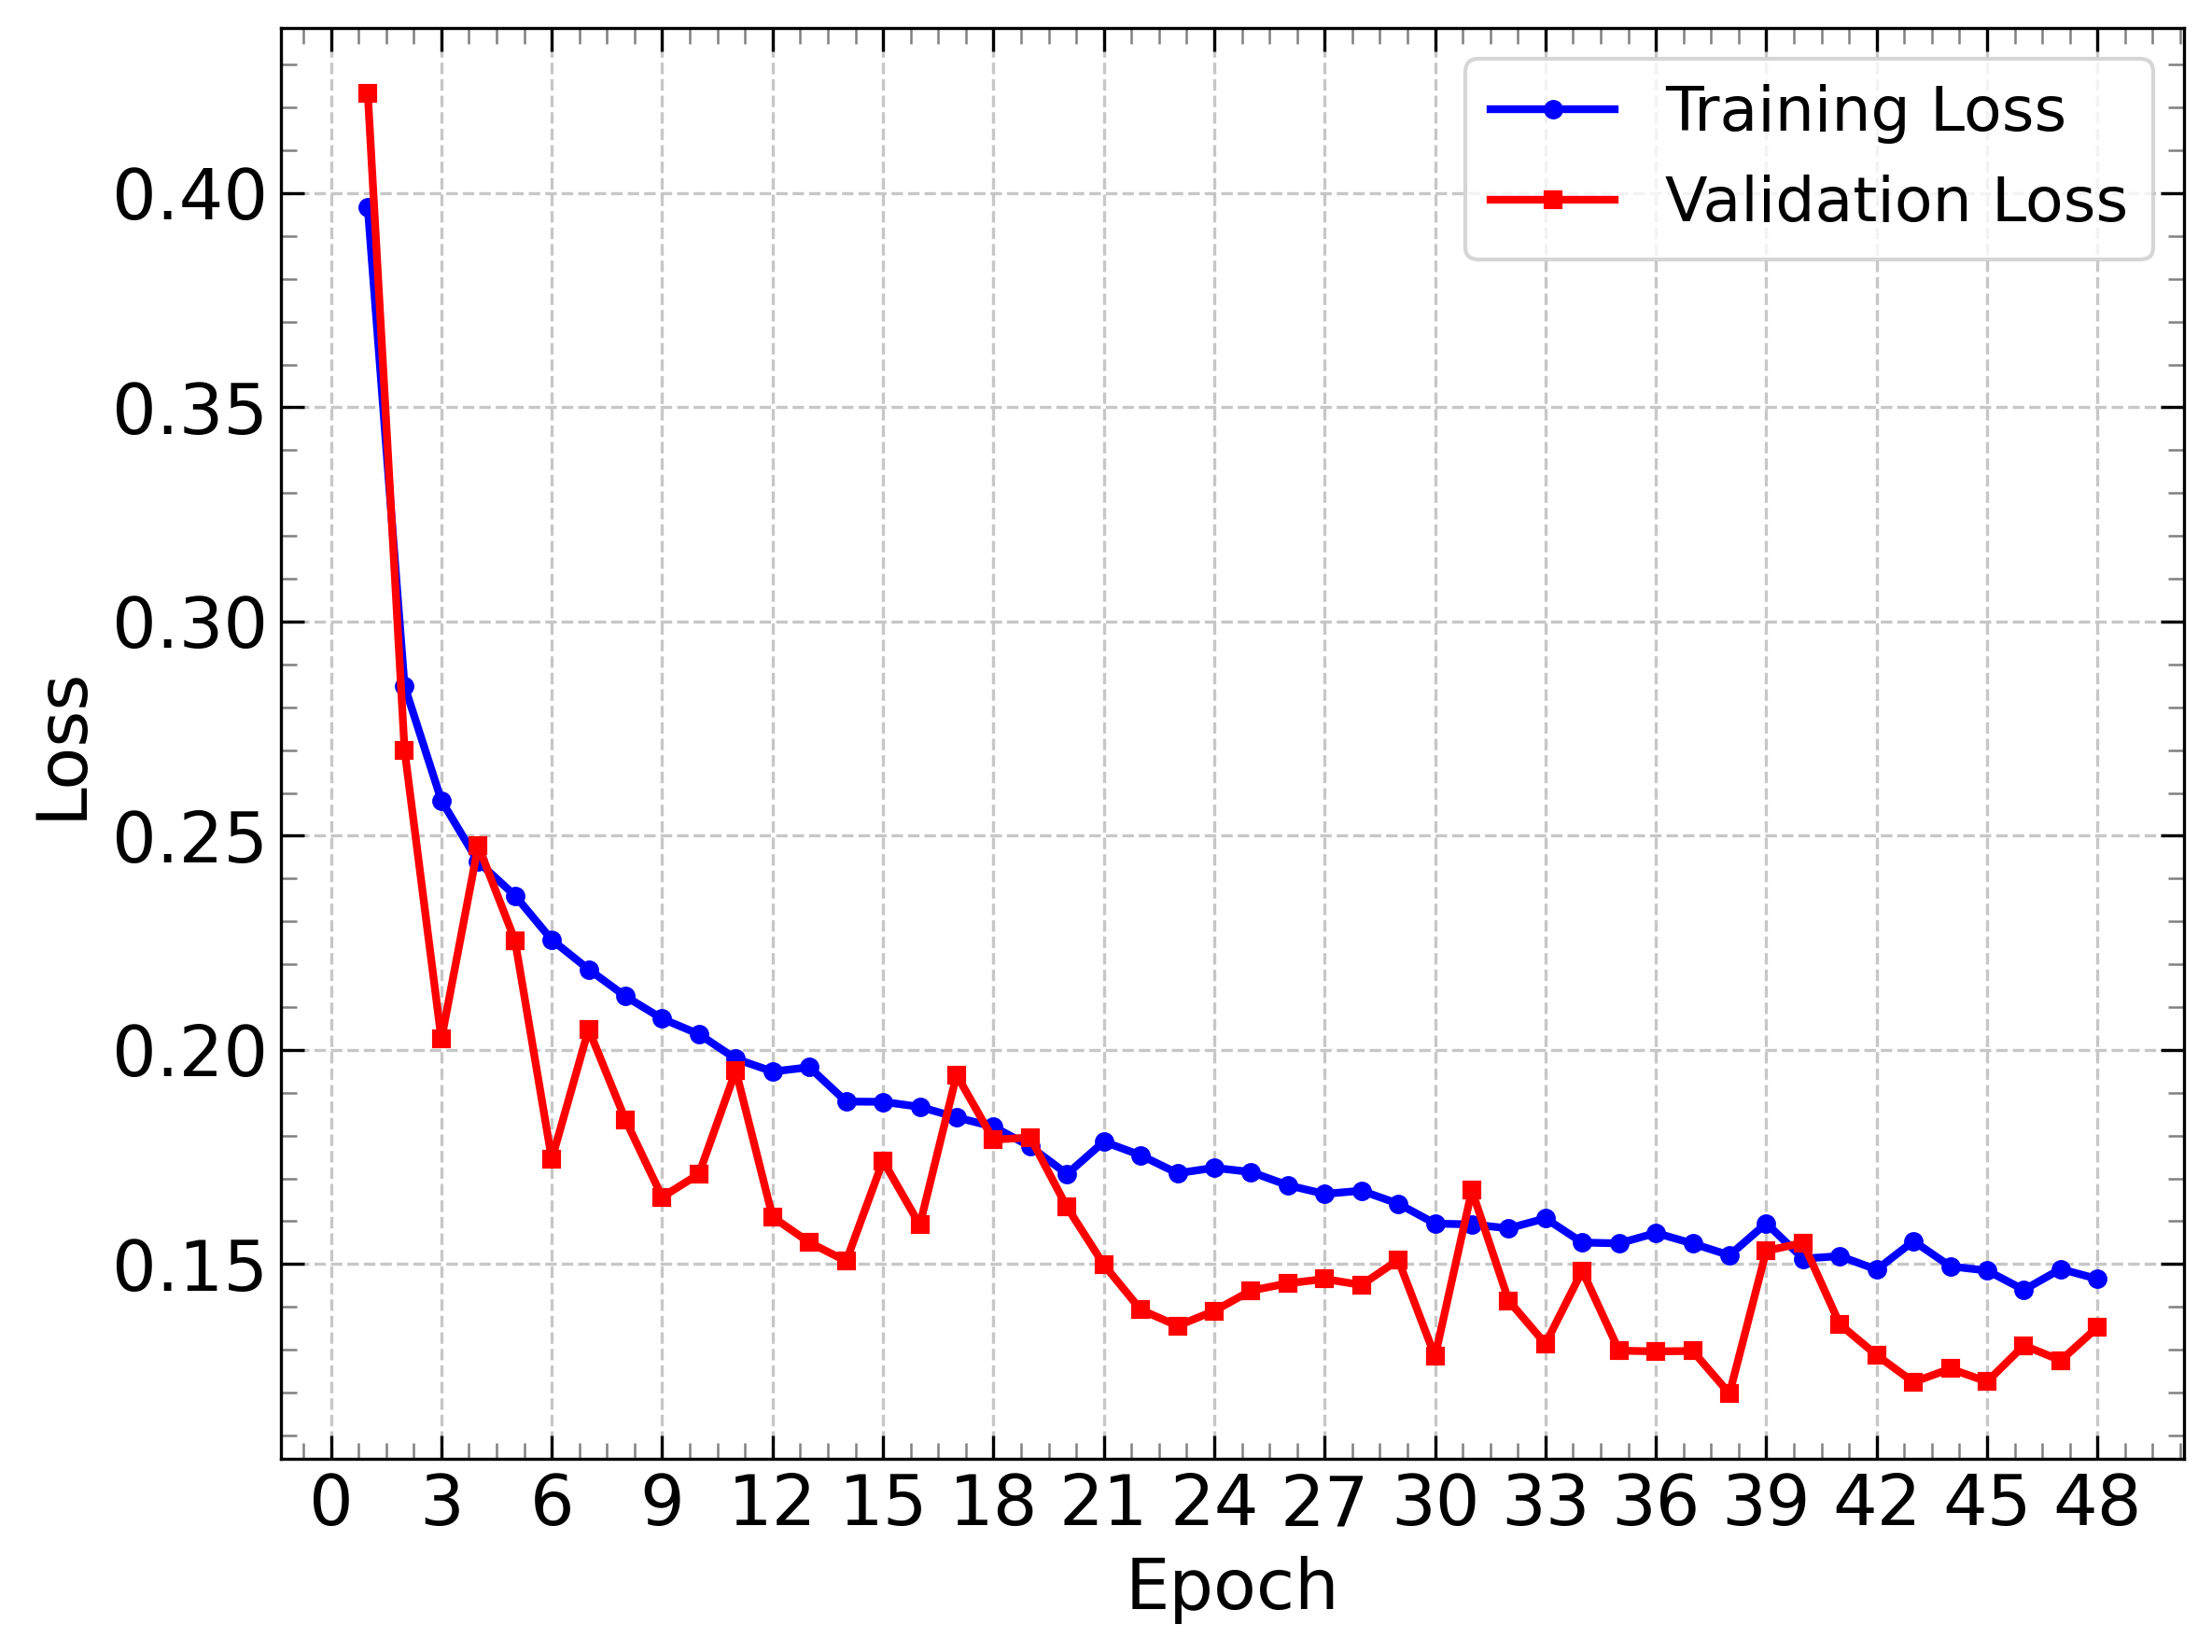

In [48]:
# Example usage:
# After training completes
loss_plot_path = 'V3Large_speedclassif_stratsplit_earlystop_frozen_losscurves'
plot_loss_curves(history, save_path=loss_plot_path, fontsize=18)

save the full model

In [41]:
# Save the final model
model_path = '/home/apyba3/PICAR-autopilot/V3Large_speedclassif_stratsplit_earlystop_frozen_speedclassif_model.keras'
model.save(model_path)
print(f"Final model saved to {model_path}")

Final model saved to /home/apyba3/PICAR-autopilot/V3Large_speedclassif_stratsplit_earlystop_frozen_speedclassif_model.keras


save model weights

In [42]:
frozen_weights_path = '/home/apyba3/PICAR-autopilot/V3Large_speedclassif_stratsplit_earlystop_frozen_weights.keras'

model.save_weights(frozen_weights_path)

clear keras session

In [43]:
tf.keras.backend.clear_session() #Clear keras session

### 2d) fine-tuning

rebuild model after clearing keras session

In [44]:
dropoutrate = 0.2
input_shape = (224,224,3)
num_classes = 1 # we're only predicting the prob of the positive class

In [51]:
# Step 2: Rebuild the model in EXACTLY the same state as when weights were saved
mobnetv3small = tf.keras.applications.MobileNetV3Large(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

# Create model with the SAME architecture as when saving
model = tf.keras.Sequential([
  mobnetv3small,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

# IMPORTANT: Set trainable to False BEFORE loading weights
# This matches the state when weights were saved
mobnetv3small.trainable = False

# Step 3: Compile the model
# The optimizer doesn't need to match, but having it compiled is important
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.F1Score(name='f1_score')]
)

# Step 4: Load the weights
model.load_weights(frozen_weights_path)

# Step 5: NOW you can set trainable to True for fine-tuning
mobnetv3small.trainable = True

# Step 6: Re-compile with appropriate learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.F1Score(name='f1_score')]
)

# Verify model structure
model.summary()

print("Successfully loaded weights and prepared model for fine-tuning!")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d_2  (None, 960)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_8 (Dropout)         (None, 960)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               246016    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 128)              

Initiate fine-tuning training

In [52]:
# Define checkpoint directory and create it if it doesn't exist
checkpoint_dir = '/home/apyba3/PICAR-autopilot/V3Large_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define checkpoint filepath for the finetuned model
checkpoint_filepath = os.path.join(checkpoint_dir, 'V3Large_speedclassif_stratsplit_earlystop_finetune_checkpoint.keras')

# Use the existing CustomModelCheckpoint class (no need to redefine it)
# Just create a new instance with the updated filepath
custom_checkpoint = CustomModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Define epoch callback 
epoch_callback = LambdaCallback(
    on_epoch_begin=lambda epoch, logs: print(f"\nStarting Epoch {epoch + 1}..."),
    on_epoch_end=lambda epoch, logs: print(f"Completed Epoch {epoch + 1}, Loss: {logs['loss']:.4f}, Val Loss: {logs['val_loss']:.4f}")
)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.001,
    mode='min',
    restore_best_weights=True,  # This loads the best weights into model memory when stopping
    verbose=1
)

# Train with both callbacks
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[custom_checkpoint, epoch_callback, early_stopping]
)


Starting Epoch 1...
Epoch 1/100


690/690 [==============================] - ETA: 0s - loss: 1.9994 - accuracy: 0.8985 - f1_score: 0.9147
Epoch 1: val_loss improved from inf to 1.1208
Saving model to /home/apyba3/PICAR-autopilot/V3Large_checkpoints/V3Large_speedclassif_stratsplit_earlystop_finetune_checkpoint.keras
Completed Epoch 1, Loss: 1.9994, Val Loss: 1.1208
690/690 [==============================] - 687s 974ms/step - loss: 1.9994 - accuracy: 0.8985 - f1_score: 0.9147 - val_loss: 1.1208 - val_accuracy: 0.7521 - val_f1_score: 0.8599

Starting Epoch 2...
Epoch 2/100
690/690 [==============================] - 675s 970ms/step - loss: 0.1486 - accuracy: 0.9522 - f1_score: 0.9277 - val_loss: 1.3116 - val_accuracy: 0.7448 - val_f1_score: 0.8599

Starting Epoch 3...
Epoch 3/100
690/690 [==============================] - 674s 968ms/step - loss: 0.0910 - accuracy: 0.9656 - f1_score: 0.9312 - val_loss: 1.6175 - val_accuracy: 0.7517 - val_f1_score: 0.8599

Starting Epoch 4...
Epoch 4/100
690/690 [============================

: 

In [ ]:
# This will save the best weights (as already restored by EarlyStopping)
model.save_weights('/home/apyba3/PICAR-autopilot/V3Large_speedclassif_stratsplit_earlystop_finetune_weights.weights.keras')


Loss curves saved to stratifiedsplit_extrabendata_finetune_earlystop_mbnetv3small_losscurves.pdf and stratifiedsplit_extrabendata_finetune_earlystop_mbnetv3small_losscurves.png


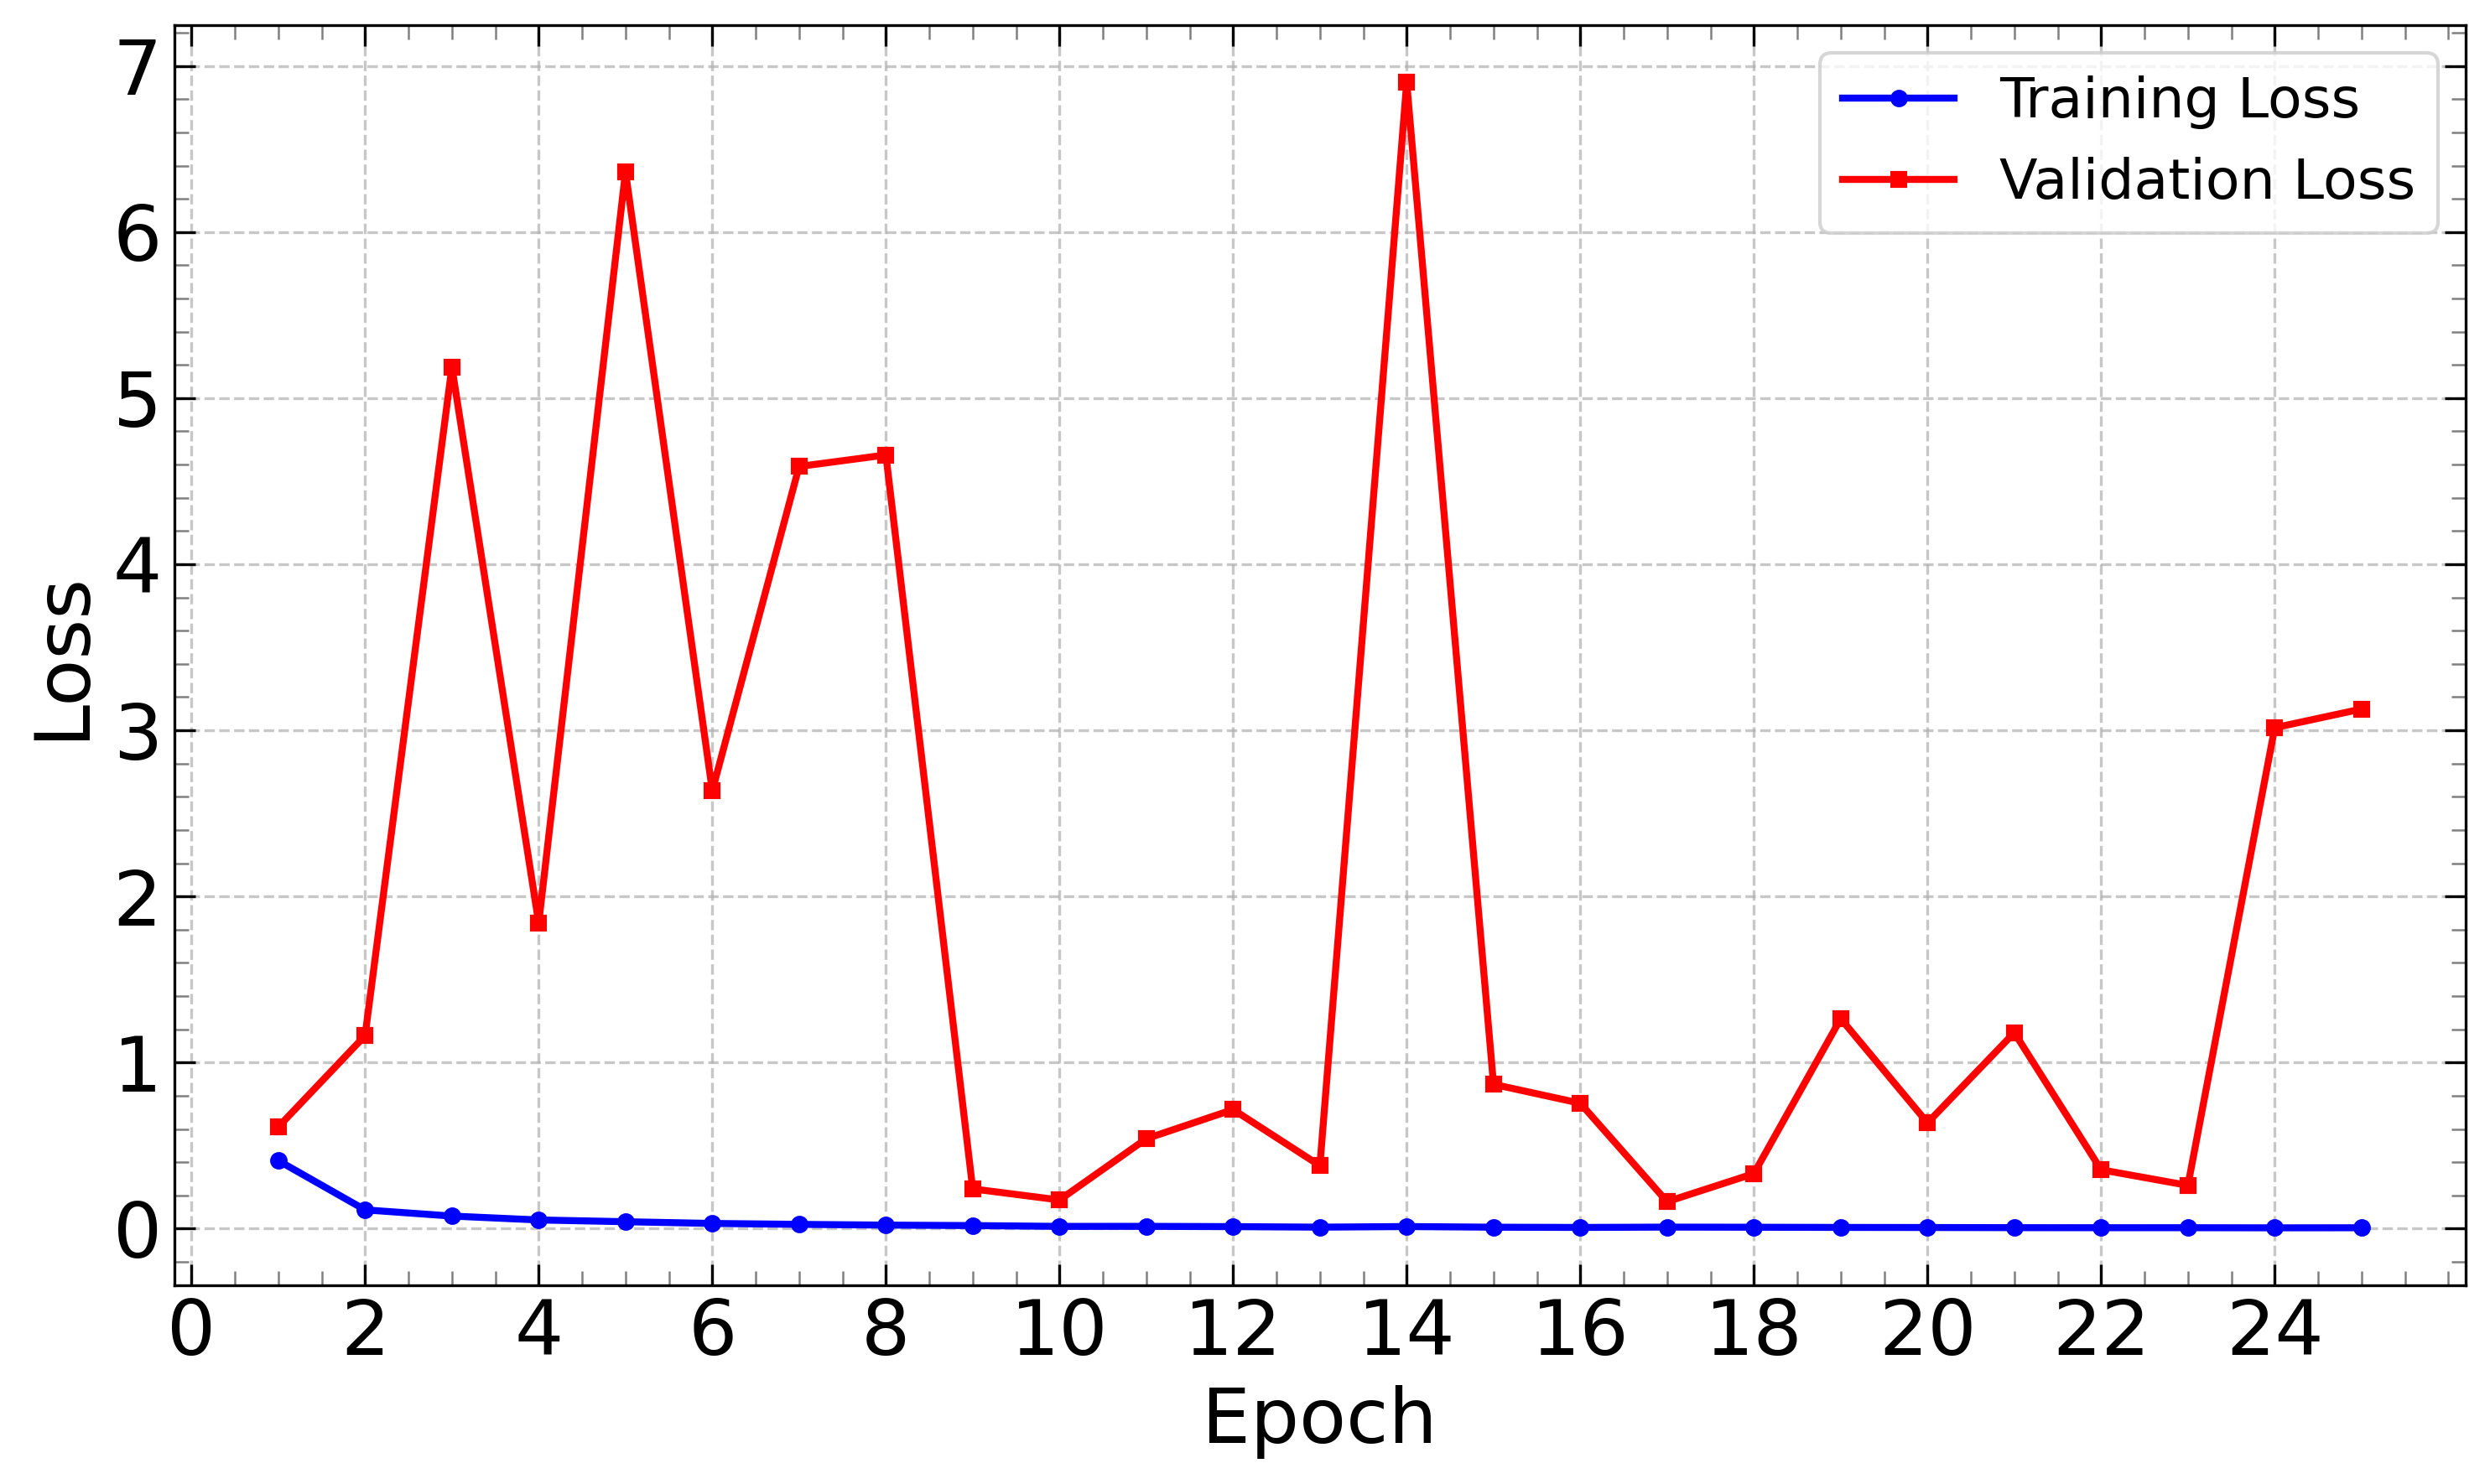

In [ ]:
# Example usage:
# After training completes
loss_plot_path = 'V3Large_speedclassif_stratsplit_earlystop_finetune_losscurves'
plot_loss_curves(history, save_path=loss_plot_path, fontsize=22)

save the model

In [ ]:
# Save the final model
model_path = '/home/apyba3/PICAR-autopilot/V3Large_speedclassif_stratsplit_earlystop_finetune_model.keras'
model.save(model_path)
print(f"Final model saved to {model_path}")

Final model saved to /home/apyba3/PICAR-autopilot/autopilot/models/BenTyler_extradata_v3small/finetunedstratifiedsplit_extrabendata_v3small_speedclassif_model_earlystop.keras


In [ ]:
# # fine tuning and validation metrics in epoch order
# epochs = list(range(1, 21))  # Epochs 1-20

# train_loss = [
#     0.5377, 0.1384, 0.0902, 0.0674, 0.0524, 0.0396, 0.0289, 0.0252, 0.0198, 0.0194,
#     0.0165, 0.0160, 0.0128, 0.0133, 0.0097, 0.0107, 0.0092, 0.0080, 0.0087, 0.0097
# ]

# val_loss = [
#     0.5684, 0.7044, 2.4431, 2.2911, 1.3723, 0.4966, 0.1164, 0.1343, 0.4855, 0.3430,
#     0.1570, 0.0530, 1.3682, 7.3271, 0.2327, 0.8250, 0.2618, 4.4855, 0.9644, 3.3733
# ]

# train_acc = [
#     0.8695, 0.9506, 0.9667, 0.9758, 0.9818, 0.9860, 0.9898, 0.9911, 0.9935, 0.9932,
#     0.9941, 0.9944, 0.9951, 0.9953, 0.9965, 0.9964, 0.9968, 0.9973, 0.9973, 0.9969
# ]

# val_acc = [
#     0.7518, 0.7766, 0.7597, 0.7657, 0.7627, 0.8547, 0.9619, 0.9570, 0.8438, 0.9467,
#     0.9619, 0.9806, 0.8517, 0.7524, 0.9625, 0.8723, 0.9249, 0.7663, 0.8456, 0.7900
# ]

# 3) CLASSIFICATION SPEED Test-Set Predictions

a) load in test data

b) convert test images to numerical RGB feature maps

c) generate predictions on the test set

d) correctly format the predictions into a pandas dataframe

e) save predictions to a file inside the hpc (to then later send from hpc to my laptop)

### 3a) load in test data

In [ ]:
image_folder_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data'
# image_folder_path = '/home/ppyt13/machine-learning-in-science-ii-2025/test_data/test_data' # tylers file path
image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'
imagefilepaths_df.head()

,image_file_paths
image_id,
1,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/1.png
2,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/2.png
3,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/3.png
4,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/4.png
5,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/5.png


### 3b) convert test images to numerical RGB feature maps

In [ ]:
def process_image_no_label(image_path, resized_shape=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Use decode_png for PNG images
    image = tf.image.resize(image, resized_shape)  # Resize to uniform shape
    image = image / 255.0  # Normalize pixel values to [0,1]
    return image

test_dataset = tf.data.Dataset.from_tensor_slices((imagefilepaths_df["image_file_paths"]))

test_dataset = test_dataset.map(process_image_no_label, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

### 3c) generate predictions on test set

In [ ]:
predictions = model.predict(test_dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step


### 3d) correctly format the predictions into a pandas dataframe

In [ ]:
predictions_df = pd.DataFrame(predictions, columns=['speed'])

In [ ]:
predictions_df.head()

,speed
0,1.370914e-25
1,1.000000e+00
2,9.999998e-01
3,1.000000e+00
4,9.998439e-01


In [ ]:
predictions_df[predictions_df['speed'] > 0.5] = 1
predictions_df[predictions_df['speed'] < 0.5] = 0

predictions_df['speed'] = predictions_df['speed'].astype(int)

In [ ]:
predictions_df.head()

,speed
0,0
1,1
2,1
3,1
4,1


In [ ]:
predictions_df['speed'].value_counts()

speed
1    516
0    504
Name: count, dtype: int64

### 3e) save predictions to a file inside the hpc (to then later send from hpc to my laptop)

In [ ]:
predictions_df.to_csv('/home/apyba3/mobnetv3small_speedclassification_withvalidation_withpetrudata.csv')